In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2
import numpy as np

# Defining functions
 **Histogram**
 Generates a histogram, with 256 bins

 **Otsu binarization**
 Aiming to find a threshold that maximizes variance $\sigma$ between classes by computing sums of probabilities up to threshold $t$:

 - $w_0(t)$: the probability of the background class
 - $w_1(t)$: the probability of the foreground class
 - $\mu_0(t)$: the mean intensity of the bg-class
 - $\mu_1(t)$: the mean intensity of the fg-class

 The formula for the between-class variance:
 $\sigma^2(t)=w_0(t)*w_1(t)*(\mu_0(t)-\mu_1(t))^2$, we select $t$ that maximize $\sigma^2(t)$

 **Distance transform**
 The distance transform is computed via manhattan (cityblock) distance $dt[i,j] = |i_0-i_1|+|j_0-j_1|$, where $i_0,j_0$ represents the current pixel were calculating the distances for, while $i_1,j_1$ is the position of the nearest foreground pixel

In [7]:
I = cv2.imread('bacteria.tif', cv2.IMREAD_GRAYSCALE)

def hist(I):
    """
    Input: Gray image
    Output: Histogram
    """
    histo = [0] * 256
    for row in I:
        for p in row:
            histo[p] += 1
    return histo

def binarize_otsu(I):
    """
    Input: Gray image
    Output: Thresholded image
    """
    histogram = hist(I)
    total_pixels = sum(histogram)
    probs = [h / total_pixels for h in histogram]
    max_variance = 0

    #thresholds
    for t in range(256): 
        #w0= sum of p(pixel \in background|threshold)
        w0 = sum(probs[:t + 1])
        w1 = sum(probs[t + 1:])
        #means
        mu0 = sum(i * probs[i] for i in range(t + 1)) / w0 if w0 > 0 else 0
        mu1 = sum(i * probs[i] for i in range(t + 1, 256)) / w1 if w1 > 0 else 0
        variance = w0 * w1 * (mu0 - mu1) ** 2

        #maximize between-class variance
        if variance > max_variance:
            max_variance = variance
            optimal_thresh = t

    B = (I > optimal_thresh).astype(np.uint8)
    return B

def distance_transform(I):
    """
    Input: Binary image
    Output: Distance transform
    """
    #manhattan
    dt = np.full_like(I, np.inf, dtype=float)

    for i in range(I.shape[0]):
        for j in range(I.shape[1]):
            if I[i, j] == 1:
                dt[i, j] = 0 # I(i,j) if fg
            else:
                if i > 0:
                    dt[i, j] = min(dt[i, j], dt[i-1, j] + 1)
                if j > 0:
                    dt[i, j] = min(dt[i, j], dt[i, j-1] + 1)
    for i in range(I.shape[0] - 1, -1, -1):
        for j in range(I.shape[1] - 1, -1, -1):
            if I[i, j] == 0:  # I(i,j) is bg
                if i < I.shape[0] - 1:
                    dt[i, j] = min(dt[i, j], dt[i+1, j] + 1)
                if j < I.shape[1] - 1:
                    dt[i, j] = min(dt[i, j], dt[i, j+1] + 1)
    return dt

def erosion(I, strel):
    """
    Input: Binary image, structuring element
    Output: eroded image
    """
    m, n = I.shape
    k_m, k_n = strel.shape
    pad_m = k_m // 2
    pad_n = k_n // 2
    output = np.zeros_like(I)
    
    # for pixel
    for i in range(pad_m, m - pad_m):
        for j in range(pad_n, n - pad_n):
            region = I[i - pad_m:i + pad_m + 1, j - pad_n:j + pad_n + 1]
            if np.all(region >= strel):  #erosion "all"
                output[i, j] = 1
    return output

def dilation(I, strel):
    """
    Input: Binary image, structuring element
    Output: dilated image
    """
    m, n = I.shape
    k_m, k_n = strel.shape
    pad_m = k_m // 2
    pad_n = k_n // 2
    output = np.zeros_like(I)
    for i in range(pad_m, m - pad_m):
        for j in range(pad_n, n - pad_n):
            region = I[i - pad_m:i + pad_m + 1, j - pad_n:j + pad_n + 1]
            if np.any(region == 1):
                output[i, j] = 1
    return output

def disk(radius):
    diameter = 2 * radius + 1
    strel = np.zeros((diameter, diameter), dtype=int)
    center = radius
    for i in range(diameter):
        for j in range(diameter):
            distance = np.sqrt((i - center) ** 2 + (j - center) ** 2)
            if distance <= radius:
                strel[i, j] = 1
    return strel

Text(0.5, 1.0, 'Eroted')

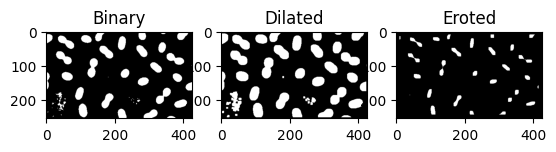

In [13]:
binary = 1 - binarize_otsu(I)
strel = disk(2)
binary_del = dilation(binary, strel)
strel = disk(8)
binary_er = erosion(binary_del, strel)

plt.figure(1)
plt.subplot(1,3,1)
plt.imshow(binary, cmap='gray')
plt.title('Binary')
plt.subplot(1,3,2)
plt.imshow(binary_del, cmap='gray')
plt.title('Dilated')
plt.subplot(1,3,3)
plt.imshow(binary_er, cmap='gray')
plt.title('Eroted')

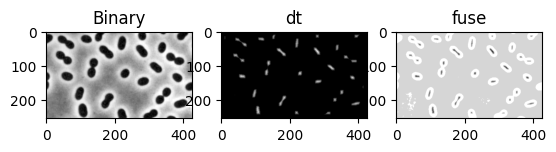

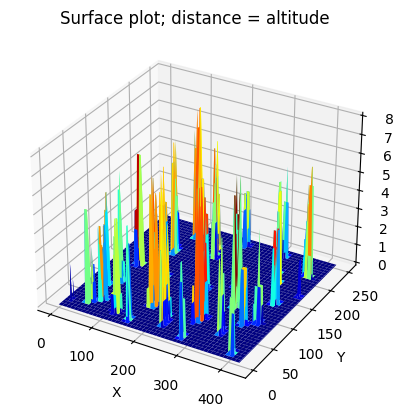

In [33]:
distance = distance_transform(1 - binary_er)
distance_normalized = cv2.normalize(distance, None, 0, 255, cv2.NORM_MINMAX)
distance_normalized = distance_normalized.astype(np.uint8)
fused = cv2.addWeighted(binary*255, 0.4, 255 - distance_normalized, 0.9, 0.5)



plt.figure()
plt.subplot(1,3,1)
plt.imshow(I, cmap='gray')
plt.title('Binary')
plt.subplot(1,3,2)
plt.imshow(distance, cmap='gray')
plt.title('dt')
plt.subplot(1,3,3)
plt.imshow(fused, cmap='gray')
plt.title('fuse')

X, Y = np.meshgrid(np.arange(distance.shape[1]), np.arange(distance.shape[0]))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, distance, cmap='jet')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Intensity (Altitude)')
plt.title('Surface plot; distance = altitude')
plt.show()